# Remained questions from the previous chapter

In the previous chapter we built a toy model using merely category tokens.

It works ok but there were two questions left:

  * Why some words are mis-classified?

  * Can we use the output from the toy model directly on the original problem?

In this chapter we will take a closer look at the second question, and eventually try to answer the first question.

**We start from loading the datasets, including those cached in previous steps**

The dataset files were not uploaded to this github repo for information safety consideration.

In [1]:
import pandas as pd

# Raw dataset with basic clean up to remove corruption data
df_sku_clean = pd.read_csv('df_sku_clean.csv')

# A mapping from original category token to normalized token
df_category_token_wc = pd.read_csv('df_category_token_wc.csv')

# A dataset of normalized category token with word vectors and class ids labeled by K-means++
df_category_token_normalized_wc = pd.read_csv('df_category_token_normalized_wc.csv')

**Then we have a closer look at the category token column in the original (cleaned) dataset**

We will call `e_matched_tokens_categories_formatted` as `category_token` in this document.

In [2]:
df_sku_clean[['e_matched_tokens_categories_formatted']]

,e_matched_tokens_categories_formatted
0,"['Bags', 'Laptop Bag']"
1,['Tablet Sleeve']
2,"['Bags', 'Cases', 'Laptop Case']"
3,"['Cases', 'Tablet Sleeve']"
4,"['Bags', 'Laptop Case']"
...,...
20101,['Polo']
20102,['Polo Shirt']
20103,"['Long Sleeves', 'Long-Sleeve', 'Polo Shirt']"
20104,['Polo Shirt']


**Let's apply the normalization mapping from `df_category_token_wc` to `df_sku_clean`**

In [3]:
category_token_mapping = df_category_token_wc[
    ['category_token',
     'category_token_normalized'
    ]
].set_index('category_token')

In [4]:
def category_tokens_mapping(token_array_str):
    from ast import literal_eval
    # Type information lost after saving to csv and read again
    token_array = literal_eval(token_array_str)
    
    # Normalize category token
    category_tokens_normalized = [
        category_token_mapping.loc[token].item() for token in token_array
    ]

    # Drop duplicates
    return set(category_tokens_normalized)

df_sku_clean['category_tokens_normalized'] = df_sku_clean[
    'e_matched_tokens_categories_formatted'
].apply(category_tokens_mapping)

In [5]:
df_sku_clean[['product_name', 'e_matched_tokens_categories_formatted', 'category_tokens_normalized']]

,product_name,e_matched_tokens_categories_formatted,category_tokens_normalized
0,Car print laptop bag,"['Bags', 'Laptop Bag']","{laptop bag, bag}"
1,Tablet Sleeve,['Tablet Sleeve'],{tablet sleeve}
2,Laptop Case,"['Bags', 'Cases', 'Laptop Case']","{laptop case, case, bag}"
3,Anchor Ipad Mini Tablet Sleeve - Black,"['Cases', 'Tablet Sleeve']","{tablet sleeve, case}"
4,Men's Alpha 3 Large Laptop Case - Grey,"['Bags', 'Laptop Case']","{laptop case, bag}"
...,...,...,...
20101,Fear of God ESSENTIALS Holiday Polo,['Polo'],{polo}
20102,Comme des Garcons Play Polo Shirt,['Polo Shirt'],{polo shirt}
20103,Men's Silk-Cotton Long-Sleeve Polo Shirt,"['Long Sleeves', 'Long-Sleeve', 'Polo Shirt']","{long sleeve, polo shirt}"
20104,Men's Solid Cashmere-Silk Polo Shirt,['Polo Shirt'],{polo shirt}


**Keep in mind the context and the question:**

  * The original challenge was asking for clustering 20k products to 5 or more classes
  * Our toy model groups ~200 category tokens to 5 classes
  * Each product in the original dataset is labeled with one or multiple category tokens

Question: can we assign the clustering output of ~200 category tokens as the class Id of these 20k products?

This seems quite risky at the beginning, as one product could potentially associate with more than one category tokens.

 * Do multiple category tokens for one product always agree with each other on clustering output?

 * If not, how to handle the conflict if they disagree with each other?

**To answer the question, let's find a way to estimate how much conflict exists in the `category_tokens_normalized` column**

# Network analysis

The technique we are going to apply is called network analysis, which is a part of graph theory.

We consider every category token as a node, and connect the category tokens in the same row with an edge, finally inspect the structure of the entire network.

In [6]:
import itertools
import networkx as nx

category_graph = nx.Graph()
category_tokens_set = df_sku_clean['category_tokens_normalized'].values

# Build the network from category token connections
for category_tokens in category_tokens_set:
    category_graph.add_nodes_from(category_tokens)
    category_graph.add_edges_from(itertools.combinations(category_tokens,2))

Then we draw the category token network.

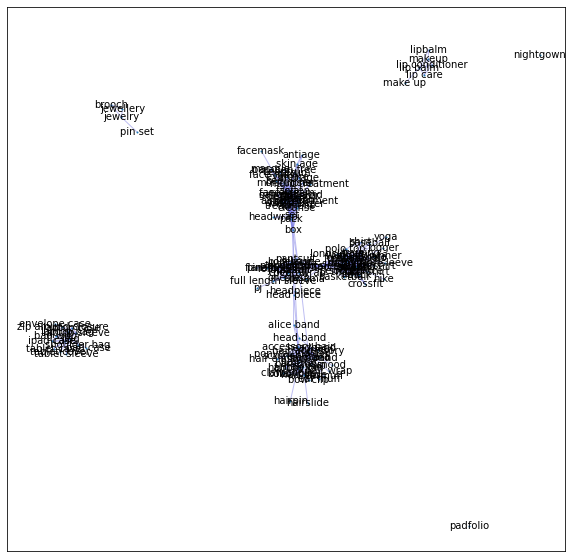

In [7]:
import matplotlib.pyplot as plt

def draw_graph(graph, figure_id, figsize):
    draw_args = {'node_size':1,
        'font_size':10,
        'edge_color':(0.5,0.5,0.9,0.5)
    }
    pos = nx.spring_layout(graph)
    plt.figure(figure_id, figsize=figsize) 
    nx.draw_networkx(
        graph,
        pos,
        **draw_args
    )
    plt.show()

draw_graph(category_graph, 0, (10,10))

The drawing isn't very clear unfortunately, but it looks very promissing, there seems exist several clusters in the graph.

Let's see how many connected components are there in the category token graph.

In [8]:
connected_category_subgraphs = list(nx.connected_components(category_graph))
num_componets = len(connected_category_subgraphs)
num_componets

7

**Let's draw all connected components**

In [9]:
def draw_subgraph(graph, figure_id, figsize):
    subset = connected_category_subgraphs[figure_id]
    subgraph = graph.subgraph(subset)
    draw_graph(subgraph, figure_id, figsize)

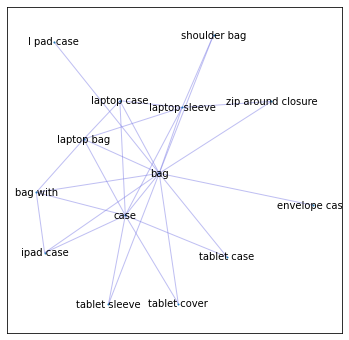

In [10]:
draw_subgraph(category_graph, 0, figsize=(6,6))

**subgraph_0 clearly presents the category `laptop/tablet bag`**

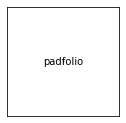

In [11]:
draw_subgraph(category_graph, 1, figsize=(2,2))

**subgraph_1 is an outlier unfortunately, it should be grouped together with `tablet bag`**

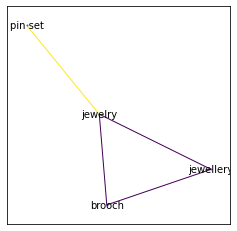

In [12]:
draw_subgraph(category_graph, 2, figsize=(4,4))

**subgraph_2 seems could be a category by it's own, but also make sense to be grouped together with `hair accessories`**

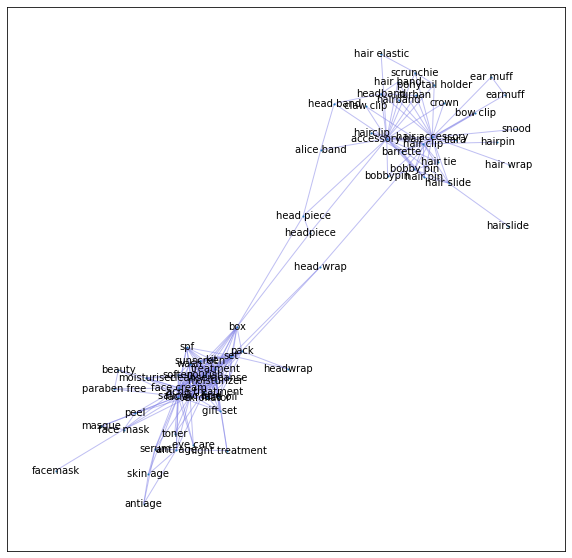

In [13]:
draw_subgraph(category_graph, 3, figsize=(10,10))

**subgraph_3 is more interesting. There are two clusters inside, one for `hair accessories`, one for `skin care`.**

There are some "bridges" connecting the two clusters. We will come back later.

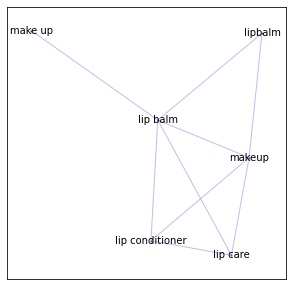

In [14]:
draw_subgraph(category_graph, 4, figsize=(5,5))

**subgraph_4 is a bit awkward, too small as a standalone cluster, too large as an outlier**

It seems better to merge subgraph_4 with `skin care`? We will come back later.

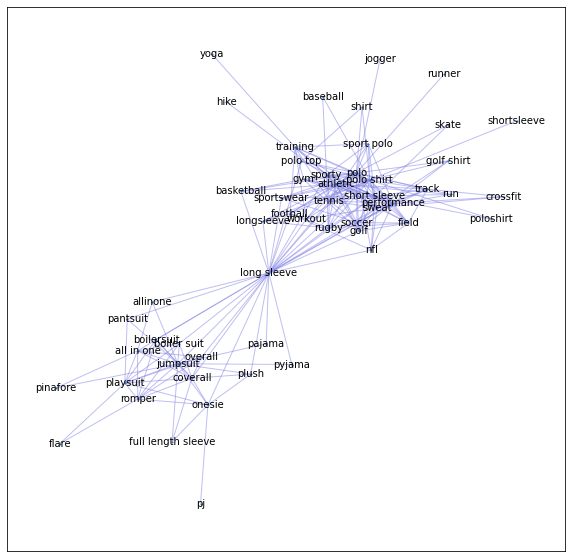

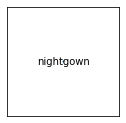

In [15]:
draw_subgraph(category_graph, 5, figsize=(10,10))
draw_subgraph(category_graph, 6, figsize=(2,2))

**subgraph_5 is the most interesting one!**

This subgraph contains two clusters, one for `polo, sport`, one for `jumpsuit, romper`

**The most interesting thing is how does the two clusters connect with each other:**

Notice the `long sleeve` right in the center between to clusters!

Why does that happen?

If we inspect the original dataset closer, we will see:

 * While `polo` is often biased to `short sleeve polo`, there also exists a lot of `long sleeve polo` in the world
 * In the original dataset, there's a significant amount of rows containing `[long sleeve, polo]` at the same time
 * On the other side, female clothings like `jumpsuit` or `romper` often appear with `long sleeve` together as well
 * As an result, `long sleeve` becomes the bridge connecting `polo` and `jumpsuit`.

If we are picky, we might question whether `long sleeve` is qualified enough as a category alone.

It's an attribute associate with some products, and might share across different categories.

Just like color and brand. Different products can have the same color, one brand can make multiple products.

**In fact, if we remove `long sleeve` and its variants `longsleeve` from the network, then we can cleanly separate the `polo` class and the `jumpsuit` class.**

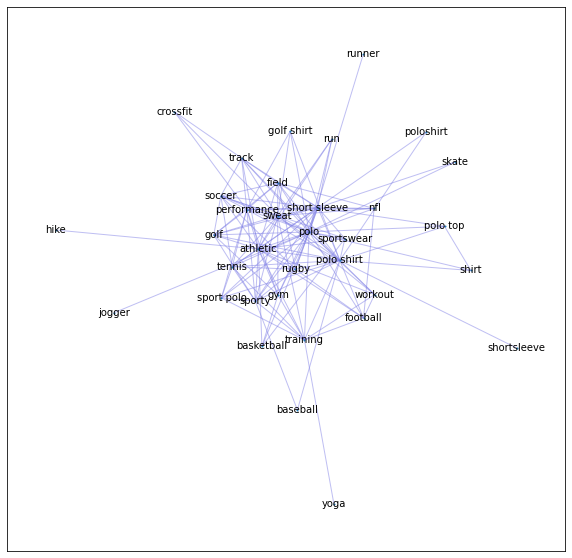

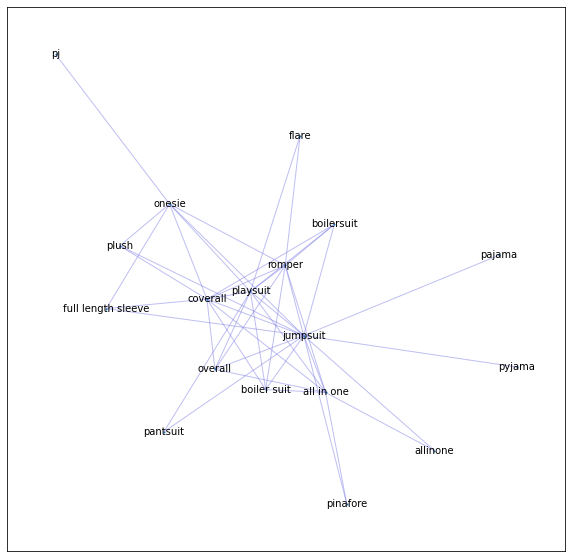

In [16]:
category_graph.remove_nodes_from({'long sleeve', 'longsleeve'})

from networkx.algorithms.dag import descendants

def draw_subgraph_with_node(graph, node):
    node_family = nx.shortest_path(graph, node).keys()
    node_family_subgraph = graph.subgraph(node_family)
    draw_graph(node_family_subgraph, 0, (10,10))

draw_subgraph_with_node(category_graph, 'polo')
draw_subgraph_with_node(category_graph, 'jumpsuit')

**The above experiment inspires us to look back at subgraph_3**

Remember that there are two clusters inside subgraph_3, one for `skin care`, one for `hair accessories`.

Can we find the connecting point(s) between two clusters?

Let's inspect subgraph_3 again.

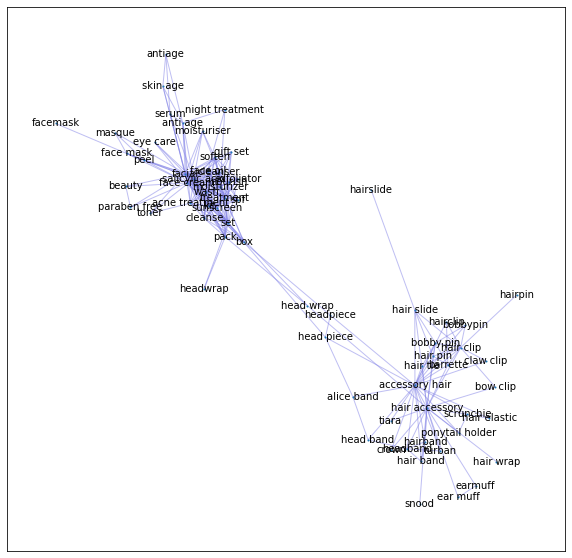

In [17]:
draw_subgraph(category_graph, 3, figsize=(10,10))

**Let's find the paths between `skin age` and `hair slide` **

In [18]:
list(nx.all_shortest_paths(category_graph, 'skin age', 'hair slide'))

[['skin age', 'facial', 'set', 'head wrap', 'hair accessory', 'hair slide'],
 ['skin age', 'facial', 'pack', 'head wrap', 'hair accessory', 'hair slide'],
 ['skin age', 'facial', 'box', 'headpiece', 'accessory hair', 'hair slide'],
 ['skin age', 'facial', 'box', 'head piece', 'accessory hair', 'hair slide']]

**Notice the special pattern here!**

The nodes `set`, `pack` and `box` are more neutral comparing to other nodes in terms of meanings.

These words can mean many things, they are very general words.

Because they are too popular, they become the intersection of `skin care` and `hair accessories`.

In fact, if we remove those nodes, `skin care` and `hair accessories` can be cleanly separated as well.

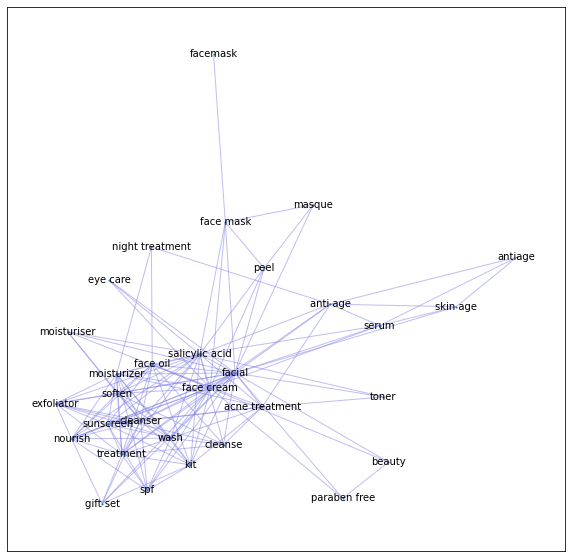

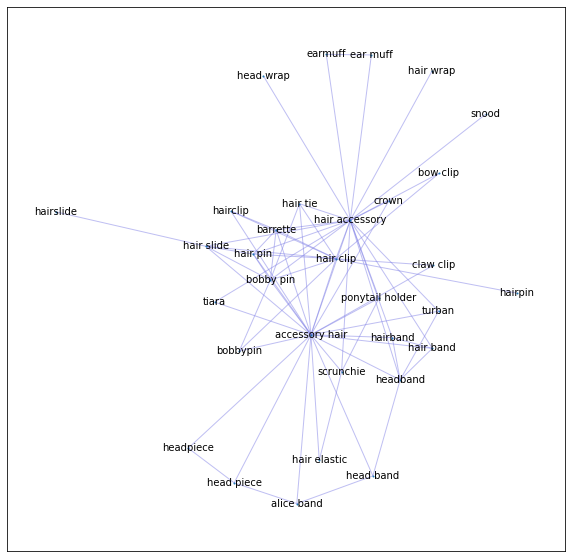

In [19]:
category_graph.remove_nodes_from({'set', 'pack', 'box'})

draw_subgraph_with_node(category_graph, 'skin age')
draw_subgraph_with_node(category_graph, 'hair slide')

**If we review the entire graph again, we can extract those components with number of nodes larger than a certain threshold, then we get a list of major clusters.**

In [20]:
connected_category_subgraphs_new = list(nx.connected_components(category_graph))

In [21]:
len(connected_category_subgraphs_new)

10

In [22]:
graph_size_threshold = 6
for connected_category_subgraph in connected_category_subgraphs_new:
    subgraph_size = len(connected_category_subgraph)
    if subgraph_size > graph_size_threshold:
        print("size:", subgraph_size)
        print(connected_category_subgraph)
        print()

size: 14
{'bag with', 'laptop bag', 'laptop sleeve', 'tablet case', 'ipad case', 'zip around closure', 'bag', 'I pad case', 'laptop case', 'tablet cover', 'shoulder bag', 'envelope case', 'tablet sleeve', 'case'}

size: 32
{'hairslide', 'hair accessory', 'scrunchie', 'hair pin', 'barrette', 'head band', 'head piece', 'tiara', 'head wrap', 'bow clip', 'headband', 'snood', 'hair wrap', 'turban', 'hair tie', 'hairpin', 'hairband', 'accessory hair', 'headpiece', 'hair clip', 'hair elastic', 'claw clip', 'ponytail holder', 'bobbypin', 'alice band', 'hair slide', 'ear muff', 'bobby pin', 'hair band', 'earmuff', 'hairclip', 'crown'}

size: 31
{'acne treatment', 'face mask', 'nourish', 'antiage', 'toner', 'paraben free', 'face cream', 'facial', 'kit', 'peel', 'serum', 'beauty', 'night treatment', 'exfoliator', 'salicylic acid', 'cleanser', 'cleanse', 'gift set', 'anti age', 'moisturiser', 'skin age', 'sunscreen', 'eye care', 'moisturizer', 'face oil', 'spf', 'facemask', 'wash', 'soften', 'trea

**How about the rest of category tokens in those small islands?**

We can either manually assign them to one of major clusters, or use word embedding to find the nearest clusters.

# Answers to the previous chapter

**Finally we can answer the remain questions**

 * Can the clustering output of category tokens apply on the original product dataset?
 
Yes.

If we remove a few ambiguous nodes, the rest of categories can be cleanly separates to different classes.

In other words, category tokens in the same row of the original dataset always belong to the same class, which means our classifier is not ambiguous.

 * Why some long_description/product_name/categories were mis-classified when using TF-IDF/Word Embedding?

Because the dataset itself is ambiguous, in many different ways.

Human use language in an ambiguous way all the time. As a result, real world dataset often follow the same ambiguity.

However, human can use commonsense knowledge and context to eliminate ambiguity, unconciously most of the time.
The same task is much more challenge for machines.

For example:

When `polo` and `long sleeve` appear together, machine learning model builds a connection between them two.

Then, when `jumpsuit` and `long sleeve` appear together, model connects them as well.

As a result, the model indirectly builds a connection between `polo` and `jumpsuit`, which makes clustering very difficult for any downstream algorithm.

When human talk about `category`, we means many different things, sometimes we mean `garment form` like `polo` vs `jumpsuit`, sometimes we mean `sleeve length` like `long sleeve` vs `short sleeve`. They are belong to different dimensions, and we have our bias / preference on deciding which dimension is more significant depends on the context.

However, machine learning model are more likely to depend on the data we feed, if the input is ambiguous, then output will be ambiguous as well, no matter whether we use TF-IDF or word embedding or anything else.

# FAQ

 * How does this graph based algorithm scale to huge dataset? It requires human intervention.
 